## 1. Introduction

Back in April 2019 an extradition bill that would have allowed for criminal suspects to be extradited to mainland China under certain circumstances was introduced in Hong Kong. Many have said this risked exposing Hong-Kongers to unfair trials and violent treatment. They also fear that the bill would give China greater influence over Hong Kong and could pose a threat to their freedom of speech.

The first protest took place on the 28th April, with tens of thousands of people marching peacefully against the extradition bill. Throughout May lawmakers attempted to come to an agreement over the bill but failed to do so on several occasions.
9th June 2019 - More than one million people took to the street to protest peacefully against the bill, however the protest turned ugly after midnight as violent protesters clash with riot police. This would mark the beginning of one of the most violent 6 months period in Hong Kong's recent history, with radical protesters clashing with police for over 50 consecutive weekends.

After having witnessed the events myself and been exposed to several media outlets, I saw that frequently newspaper and online articles were simply not reporting the truth whether it was due to lack of accurate facts or simply being bias to one side. I decided to look into this matter further.

The aim of this project is to analysis the news articles covering the Hong Kong protest and try to determine whether an outlet is pro-democracy, pro-Beijing or neutral. Natural Language Processing will be utilised to carry out sentiment analysis on the articles.

This notebook will document my process throughout this project.

## 2. Methodology

The plan was to start with South China Morning Post as they are one of the largest Hong Kong English-based news outlet, and in my opinion they are generally fairly neutral thus provided me a good baseline to compare other outlets with.
Around 2000 articles were collected spanning from July 2019 to February 2020.

## 3. Web Scraping

### 3.1. Scraping an article

Before I even begin to scape anything from the article I need to find the relevant HTML tags and content boxes for the data that I am collecting from that article. This included the article header,  summary,  timestamp,  author and the main body text. As this will be a text based analysis I did not include the article images. First let's begin by installing the modules that I will need to scrape the article.

In [1]:
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import nltk; nltk.download('stopwords'); nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The above code scrapes all the content of the news article that I need, the next step would be to write them into a CSV file. But first I will need to concatanate the summary and article text into one string. This is done by appending them to an empty list, and then using the .join method. 

I added the above code to the beginning and end of the article scraping codes. A couple of things to note:
    - In the `with open` statement I set the `encoding='utf-8-sig'` because the webpage was encoded with byte order mark (BOM).
    - I created the `.Dictwriter` object to map dictionaries onto output rows.
    - Added the try-except loop to handle errors, nothing will be written to that row in the CSV file if there is no content for that tag.

### 3.2. Scraping all the article links

#### 3.2.1 Southern China Morning Post (SCMP)
I have decided to start with scraping all the article linkes from South China Morning Post as I found them to be fairly netural and tend to cover most of the facts when available. The link I am using is https://www.scmp.com/topics/hong-kong-protests. This link contains all articles tagged to the 'Hong Kong Protest' topic.

This page uses an 'infinite scroll' feature to load more articles and in most cases an ajax request is sent, where the Request URL for the next page can easily be idenitified and used for scraping. However for this site there is no pagination used in the request URL.

Traditionally: `https://scrapingclub.com/exercise/list_infinite_scroll/?page=2`.

SCMP: `https://apigw.scmp.com/content-delivery/v1?operationName=gettopicbyentityuuid&variables=`

In order to overcome this I had to do a little more digging. A request URL is sent every time additional items are being loaded and within the GET request there is a variable called 'after'. This variable essentially determined the starting position (or page) of the current view, therefore by getting the ending position of the current page I was able to send a GET request for the next 'page'. The request was sent using an apikey and the response data was in a JSON format, from there I simple selected the relevant data and wrote them into a CSV file which included the article headline, summary, URL and updated date.

#### 3.2.2. Hong Kong Free Press (HKFP)
As every website is different, the script used to get all the news articles details from SCMP could not be reused for the HKFP site. The HKFP site have a daily archive section where the URL is https://hongkongfp.com/2020/06/21, so all I had to do was loop through a date range and scrape the metadata for each article on that particular page.
A function is used to generate the list of dates once a start & end date is given, a request is sent using the URL + custom date range and finally the metadata for each article on the requested page is collected and written to a CSV file.

### 3.3. Putting it all together

I now need to use the function written in 3.1 to read the CSV containing all the URLs and scrape all the information from each individual article.
The CSV file contains rows where there is an apostrophe, which is causing an issue when reading. To resolve this the delimiter "'" will need to be doubled for the CSV to read correctly.

The article scraping function was set to scrape 1000 articles at a time to prevent any connection errors, the whole process took around 30 minutes and 2215 articles were scraped.

## 4. Text Processing &  Analysis

### 4.1. Exploratory Data Analysis
Once I have the content scraped it is time to do some basic EDA. For example, the number of articles posted per month and most common words in the articles (excluding stop words). First the CSV file is read into a pandas DataFrame, then the date is converted from str to a datetime type.

In [6]:
df = pd.read_csv("../csv_files/scmp_article_content_all.csv", header=0)

In [7]:
df['Date']=df['date'].apply(lambda x: datetime.strptime(x, '%I:%M%p, %d %b, %Y').strftime('%Y-%m-%d'))
df['Month']=df['date'].apply(lambda x: datetime.strptime(x, '%I:%M%p, %d %b, %Y').strftime('%B'))
df.head()

,title,summary,date,main_text_title,paragraphs,url,Date,Month
0,"Protests over Yuen Long feature beer, champagn...",Largely peaceful demonstrations feature small ...,"3:55pm, 21 Feb, 2020",Peaceful lunchtime demonstrations intended to ...,At the atrium of the Landmark shopping centre ...,https://scmp.com/print/news/hong-kong/politics...,2020-02-21,February
1,Coronavirus: Beijing’s top official in Hong Ko...,Luo Huining asks city’s members of China’s leg...,"11:03pm, 20 Feb, 2020",Beijing’s top envoy in Hong Kong has written t...,"Luo Huining, the new director of Beijing’s lia...",https://scmp.com/print/news/china/politics/art...,2020-02-20,February
2,Anti-government protesters’ slogan spray-paint...,Popular protest refrain ‘Liberate Hong Kong; R...,"10:38pm, 19 Feb, 2020",The eight words in Chinese – “Liberate Hong Ko...,The popular slogan of the months-long anti-gov...,https://scmp.com/print/news/hong-kong/law-and-...,2020-02-19,February
3,Hong Kong commerce minister warns RTHK to obse...,Commerce and Economic Development Bureau which...,"5:44pm, 18 Feb, 2020","The force earlier denied the allegation, sayin...",Hong Kong’s commerce minister has warned publi...,https://scmp.com/print/news/hong-kong/politics...,2020-02-18,February
4,Videos of Hong Kong police officers dining wit...,Banquet was attended by celebrities such as Ch...,"12:18am, 18 Feb, 2020",Videos showing Hong Kong police chief Chris Ta...,The banquet on Sunday night was hosted by the ...,https://scmp.com/print/news/hong-kong/society/...,2020-02-18,February


The number of articles in a month is then counted and plotted. This is done by selecting and then grouping the 'Date' column, applying the aggregating function 'count', then finally resettihg the index.

In [21]:
new_order = [4, 0, 7, 6, 5, 1, 3, 2]
number_articles_per_month = df["Month"].groupby(df["Month"]).agg(Count='count').reset_index()
number_articles_per_month = number_articles_per_month.reindex(new_order, axis=0)
number_articles_per_month

,Month,Count
4,July,113
0,August,428
7,September,404
6,October,399
5,November,373
1,December,268
3,January,201
2,February,29


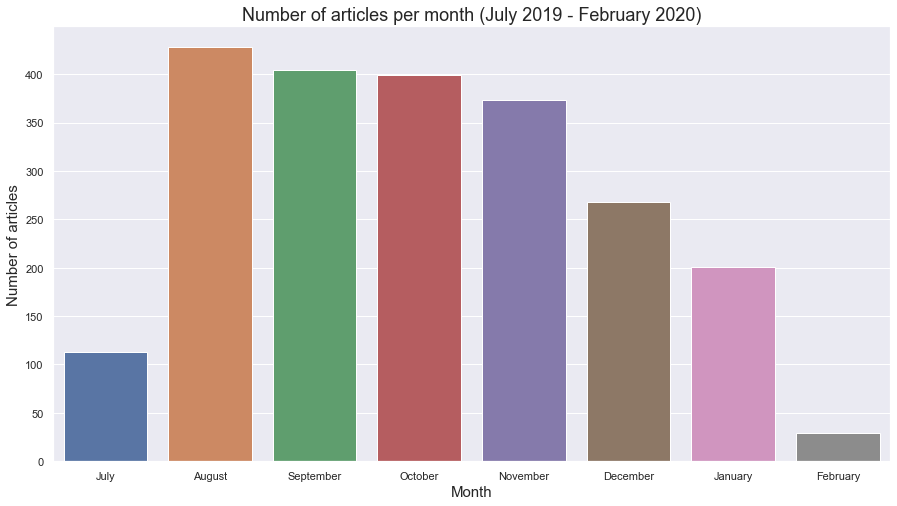

In [201]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='Month', y='Count' , data=number_articles_per_month, palette='deep')
ax.set_ylabel('Number of articles', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.set_title('Number of articles per month (July 2019 - February 2020)',fontsize=18)
plt.show()

Text(0.5, 1.0, 'The number of articles over the 6 months period (18/07/2019 - 21/02/2020)')

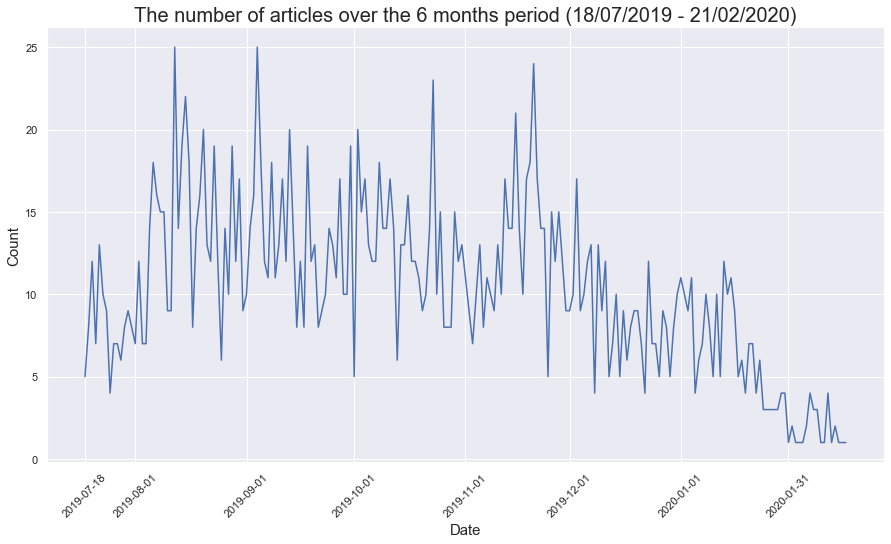

In [200]:
#Number of articles over the observed period.
articles_per_day = df["Date"].groupby(df["Date"]).agg(Count='count').reset_index()
plt.figure(figsize=(15,8))
plt.xticks([0, 14, 45, 75, 106, 135, 166, 196])
plt.xticks(rotation='45')
ax = sns.lineplot(x="Date", y="Count", data=articles_per_day)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Date', fontsize=15)
ax.set_title('The number of articles over the 6 months period (18/07/2019 - 21/02/2020)', fontsize=20)

I will need to remove punctuations from the paragraph column and convert all the text to lower case. The cleaned text is added to a new column in the dataframe.

In [191]:
df['clean_paragraphs'] = df.paragraphs.apply(lambda x: x.lower())\
    .apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))\
    .apply(lambda x: x.replace('”','').replace('“',''))
text_dataset = df['clean_paragraphs']

Let's take a look at the average number of words in each article, and the longest and shortest article in the dataset. As well as visualizing a distribution of the article word counts.

In [213]:
df['num_wds'] = df['clean_paragraphs'].apply(lambda x: len(x.split()))
print(df['num_wds'].mean())
print(df['num_wds'].max())
print(df['num_wds'].min())

675.6117381489842
3005
38


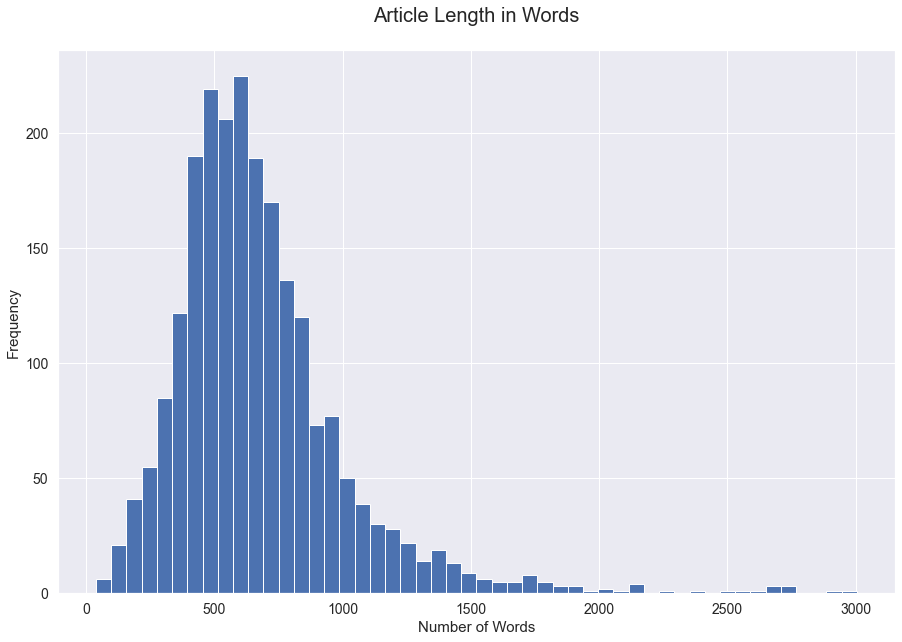

In [211]:
ax=df['num_wds'].plot(kind='hist', bins=50, fontsize=14, figsize=(15,10))
ax.set_title('Article Length in Words\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xlabel('Number of Words', fontsize=15);

Text(0.5, 0, 'Month')

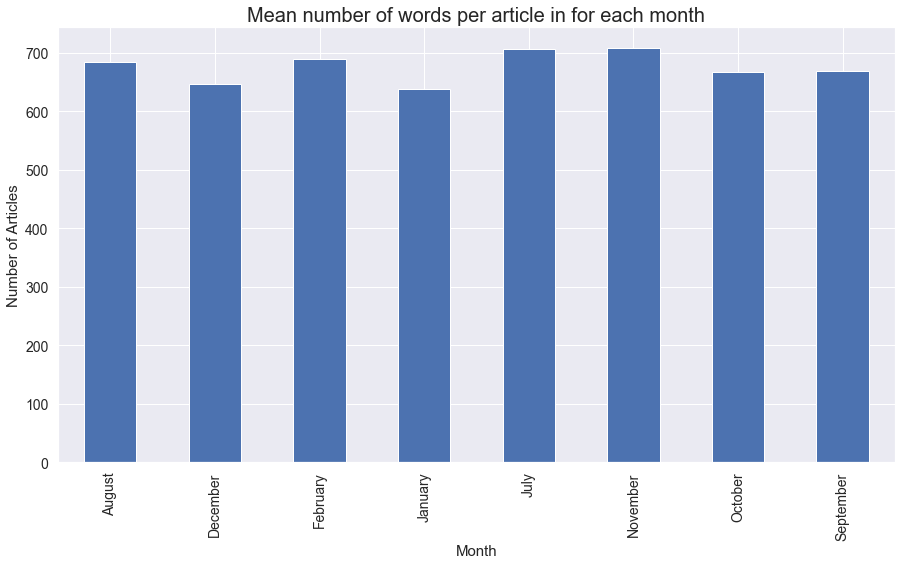

In [210]:
month_grp= df.groupby('Month')
ax=month_grp['num_wds'].aggregate(np.mean).plot(kind='bar', fontsize=14, figsize=(15,8))
ax.set_title('Mean number of words per article in for each month', fontsize=20)
ax.set_ylabel('Number of Articles', fontsize=15)
ax.set_xlabel('Month', fontsize=15)

The same can be done for number of unique words per article.

In [216]:
df['uniq_wds'] = df['clean_paragraphs'].str.split().apply(lambda x: len(set(x)))
print(df['uniq_wds'].mean())
print(df['uniq_wds'].max())
print(df['uniq_wds'].min())

329.84063205417607
1079
33


### 4.2. Text mining of the article text
I start by counting the top 10 most frequent words in the scraped data. This involves a few steps: 

1. Reading in the 'paragraph' column
2. Convert text to all lowercase and remove all punctuation
3. Splitting the string into a list where each word is a list item by using .str.split()
4. Applying the Counter container to convert the list of lists using a *list comprehension.
5. Remove stop words
6. Applying the .most_common(10) method to get the top 10 most frequent word.


*Without using list comprehension:

    c = Counter()
    for xs in seq:
        for x in set(xs):
            c[x] += 1
    
Output: {'a': 2, 'c': 2, 'b': 2, 'd': 1}


In [69]:
from collections import Counter

split_it = text_dataset.str.split()

Counter = Counter(x for xs in split_it for x in xs)
most_occur = Counter.most_common(10)
print(most_occur)

[('the', 97936), ('to', 44423), ('of', 37183), ('and', 35976), ('a', 30769), ('in', 30119), ('said', 19108), ('on', 18336), ('for', 13636), ('hong', 13232)]


The sentences will need to be tokenized into words before the stopwords can be removed. The stopword list is almost imported, and additional stopwords added.

In [139]:
tokenized_sent = []
for w in text_dataset:
    tokenized_sent.append(word_tokenize(w))

In [186]:
stoplist = stopwords.words("english")
newStopWords = ['said','The','would','also','could','–','\'','’']
stoplist.extend(newStopWords)
#print(stoplist)

In [141]:
filtered_sentence = []
for sent in tokenized_sent:
    for w in sent:
        if w not in stoplist:
            filtered_sentence.append(w)

After the text has been cleaned and split, I then count the word frequency and plot them onto bar charts.

In [142]:
from collections import Counter
sentences = (xs for xs in filtered_sentence)
clean_list = Counter(sentences)
clean_most_occur = clean_list.most_common(20)
clean_least_occur = clean_list.most_common()[-21:-1]

Text(0.5, 1.0, '20 most common words (excluding stop words)')

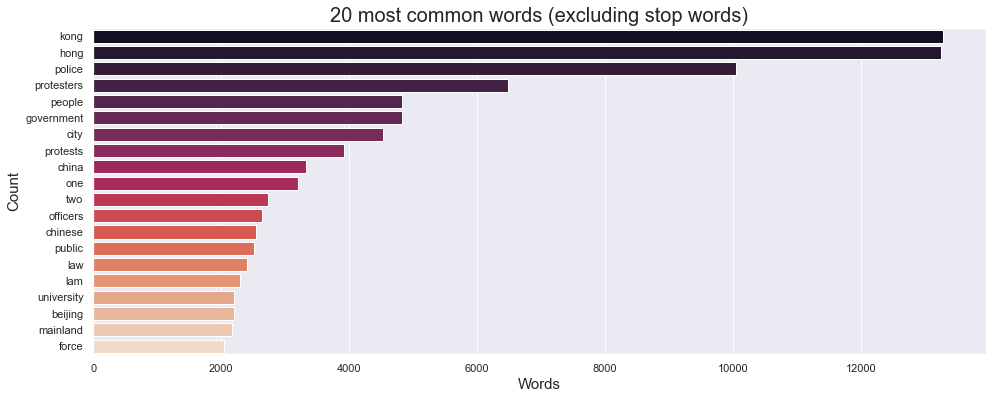

In [143]:
plt.figure(figsize=(16,6))
pd_clean_most_occur = pd.DataFrame(clean_most_occur, columns = ['Words' , 'Count'])
ax = sns.barplot(x='Count', y='Words' , data=pd_clean_most_occur, palette='rocket')
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Words', fontsize=15)
ax.set_title('20 most common words (excluding stop words)', fontsize=20)

Text(0.5, 1.0, '20 least common words')

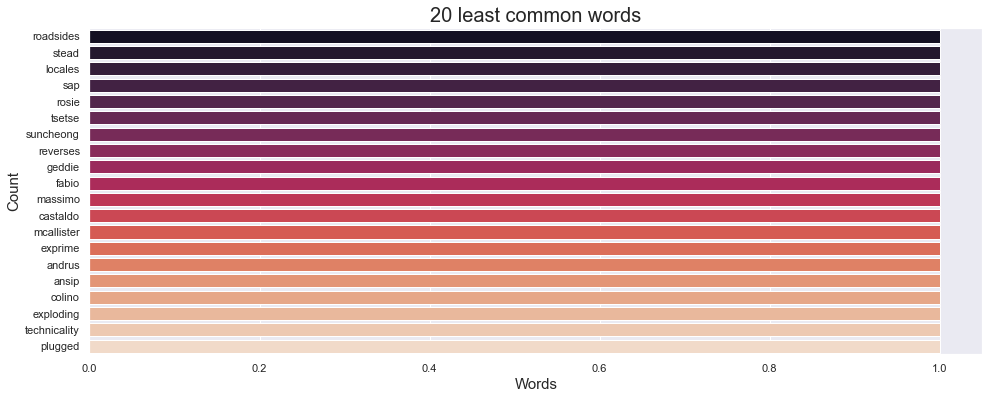

In [144]:
plt.figure(figsize=(16,6))
pd_least_occur = pd.DataFrame(clean_least_occur, columns = ['Words' , 'Count'])
ax = sns.barplot(x='Count', y='Words' , data=pd_least_occur, palette='rocket')
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Words', fontsize=15)
ax.set_title('20 least common words', fontsize=20)

### 4.3 n-grams

When analysing articles and reviews we want to find and understand the relationship between words. What words have the strongest relationship with each other? What sequances of words are most common in an article? n-grams, more specifically bigrams and trigrams (but are not limited to) can be used to examine such relationships, and often will provide a more accurate insight to the text being analysed.
For example a single word or unigram model might consider the phrase "terribly well done" negative as the words are analysed individually, whereas a trigram model would flag this as positive.

A function is used to create and plot the n-grams.

In [182]:
from nltk import ngrams
from collections import Counter

sentences = (xs for xs in filtered_sentence)
def plot_ngram(n):
    global ngrams
    new_grams = ngrams(sentences, n)
    ngrams = Counter(new_grams)
    df_ngrams = pd.DataFrame.from_dict(ngrams, orient='index',columns=['frequency']).reset_index().rename(columns={"index": "words"})
    df_ngrams = df_ngrams.sort_values(['frequency'], ascending=False)
    plt.figure(figsize=(16,6))
    ax = sns.barplot(x='frequency', y='words', data=df_ngrams[:20], palette='GnBu_d')
    ax.set_ylabel('Count', fontsize=15)
    ax.set_xlabel('Words', fontsize=15)
    ax.set_title('{}-gram'.format(n), fontsize=20)
    plt.show()

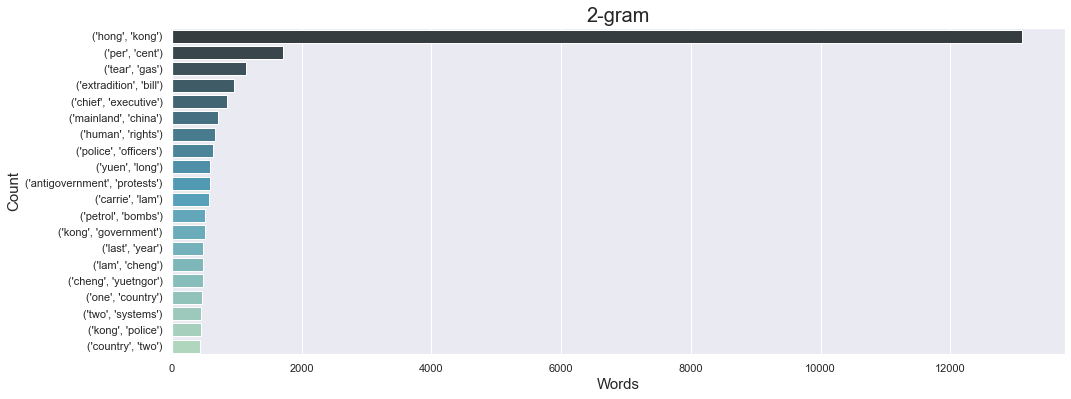

In [177]:
plot_ngram(2)

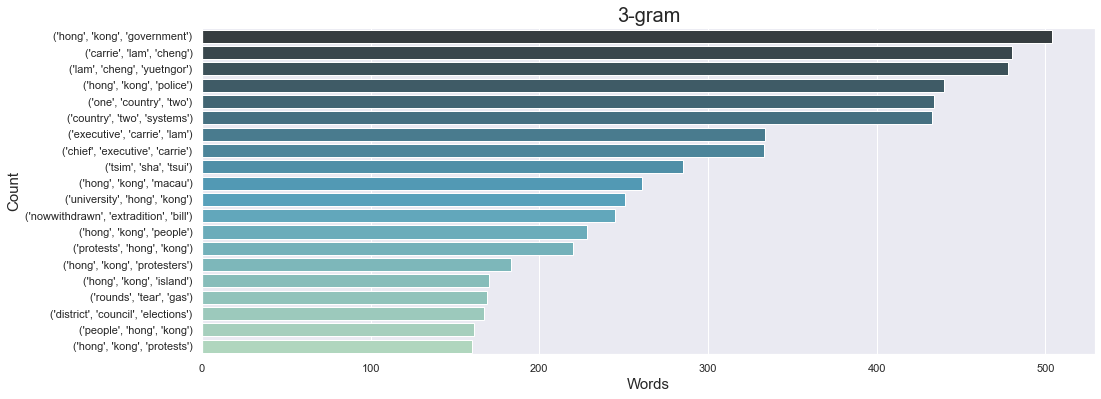

In [180]:
plot_ngram(3)

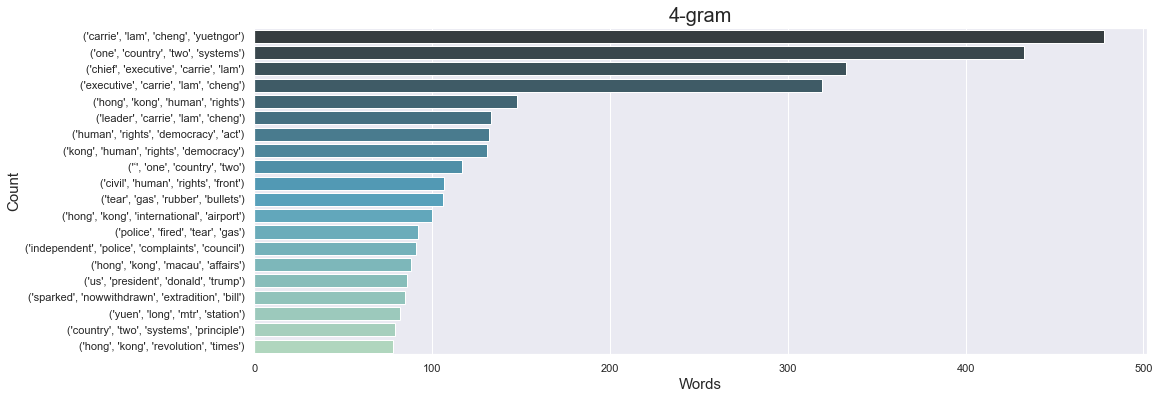

In [183]:
plot_ngram(4)

In [184]:
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df['paragraphs'])
frequencies = sum(sparse_matrix).data
bigram = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).reset_index()

In [185]:
bigram.index.names = ['words']
bigram = bigram.sort_values(['frequency'], ascending=False)
bigram

,index,frequency
words,,
223350,legislators last,97951
223371,legislature,44427
223352,legislators lawyers,37183
223382,legislature beijing,35977
223356,legislators over,30121
...,...,...
145404,final quarter,1
145400,final month,1
145399,final language,1


## 5. Sentiment Analysis

Using a function called SentimentIntensityAnalyzer() from the nltk.sentiment.vader package, we can apply it to the paragraphs to generate the polarity scores. This is done by using .apply() and lambda functions.
There are four types of scores:
 - negative
 - neutral
 - positive
 - compound

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nicom\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
df['neg'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['neg'])
df['neu'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['neu'])
df['pos'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['pos'])
df['compound'] = df['paragraphs'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [8]:
df.head()

,title,summary,date,main_text_title,paragraphs,url,Date,Month,neg,nen,pos,compound
0,"Protests over Yuen Long feature beer, champagn...",Largely peaceful demonstrations feature small ...,"3:55pm, 21 Feb, 2020",Peaceful lunchtime demonstrations intended to ...,At the atrium of the Landmark shopping centre ...,https://scmp.com/print/news/hong-kong/politics...,2020-02-21,February,0.112,0.824,0.064,-0.9786
1,Coronavirus: Beijing’s top official in Hong Ko...,Luo Huining asks city’s members of China’s leg...,"11:03pm, 20 Feb, 2020",Beijing’s top envoy in Hong Kong has written t...,"Luo Huining, the new director of Beijing’s lia...",https://scmp.com/print/news/china/politics/art...,2020-02-20,February,0.061,0.850,0.089,0.9695
2,Anti-government protesters’ slogan spray-paint...,Popular protest refrain ‘Liberate Hong Kong; R...,"10:38pm, 19 Feb, 2020",The eight words in Chinese – “Liberate Hong Ko...,The popular slogan of the months-long anti-gov...,https://scmp.com/print/news/hong-kong/law-and-...,2020-02-19,February,0.085,0.876,0.038,-0.8442
3,Hong Kong commerce minister warns RTHK to obse...,Commerce and Economic Development Bureau which...,"5:44pm, 18 Feb, 2020","The force earlier denied the allegation, sayin...",Hong Kong’s commerce minister has warned publi...,https://scmp.com/print/news/hong-kong/politics...,2020-02-18,February,0.043,0.935,0.022,-0.8789
4,Videos of Hong Kong police officers dining wit...,Banquet was attended by celebrities such as Ch...,"12:18am, 18 Feb, 2020",Videos showing Hong Kong police chief Chris Ta...,The banquet on Sunday night was hosted by the ...,https://scmp.com/print/news/hong-kong/society/...,2020-02-18,February,0.059,0.854,0.087,0.9262


In [11]:
pos_review = [j for i, j in enumerate(df['paragraphs']) if df['pos'][i] > 0.2]
neu_review = [j for i, j in enumerate(df['paragraphs']) if df['neu'][i] >= -0.2]
neg_review = [j for i, j in enumerate(df['paragraphs']) if df['neg'][i] < -0.2]

In [13]:
print("Percentage of positive review: {}%".format(len(pos_review)*100/len(df['paragraphs'])))
print("Percentage of neutral review: {}%".format(len(neu_review)*100/len(df['paragraphs'])))
print("Percentage of negative review: {}%".format(len(neg_review)*100/len(df['paragraphs'])))

Percentage of positive review: 0.045146726862302484%
Percentage of neutral review: 100.0%
Percentage of negative review: 0.0%
